Tentacle-based planning: {'linear_velocity': 1.0, 'angular_velocity': 0.5, 'current_x': 0, 'current_y': 0, 'current_theta': 0, 'goal_x': 5, 'goal_y': 5, 'goal_theta': 0}
Straight-line planning: {'linear_velocity': 1.0, 'angular_velocity': 0.5, 'current_x': 0, 'current_y': 0, 'current_theta': 0, 'goal_x': 5, 'goal_y': 5, 'goal_theta': 0}


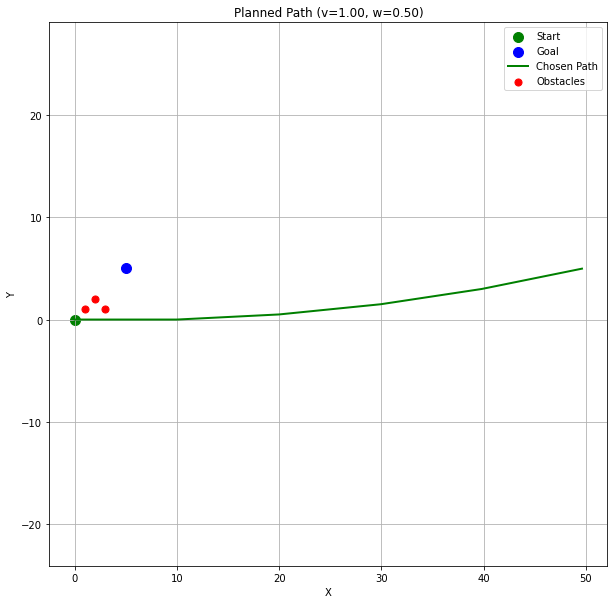

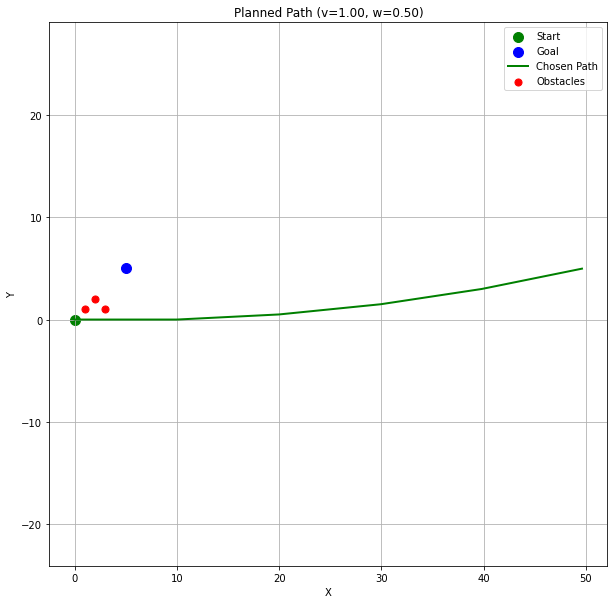

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow

# For Jarrod

class TentaclePlanner:
    def __init__(self, obstacles=[], dt=0.1, steps=5, alpha=1, beta=0.1, max_linear_velocity=0.23, max_angular_velocity=1.26):
        self.dt = dt
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        self.obstacles = obstacles
        self.max_linear_velocity = max_linear_velocity
        self.max_angular_velocity = max_angular_velocity
        
        # Still to implement:
        self.max_tolerance = 0.05 # meters, how far we can be from the target before we say we're not at the target
            # right now, if we overshoot a position, the planner tries to push us in the opposite direction and overshoots again
            # so we should have some sort of error tolerance
            
        # An awareness of how fast we can accelerate - or maybe limit the 'jump' between current velocity and desired velocity
        # - Could be an average of the current velocity and desired velocity
        
        # Generate tentacles based on max velocities
        self.generate_tentacles()

    def generate_tentacles(self):
        # Generate a range of linear and angular velocities
        linear_velocities = np.linspace(-self.max_linear_velocity, self.max_linear_velocity, 5)
        angular_velocities = np.linspace(-self.max_angular_velocity, self.max_angular_velocity, 5)
        
        self.tentacles = [(v, w) for v in linear_velocities for w in angular_velocities]
        self.tentacles.append((0.0, 0.0))  # Add stop option

    def roll_out(self, v, w, goal_x, goal_y, goal_th, x, y, th):
        for _ in range(self.steps):
            x = x + self.dt * v * np.cos(th)
            y = y + self.dt * v * np.sin(th)
            th = (th + w * self.dt)

            if self.check_collision(x, y):
                return np.inf

        # Wrap angle error -pi,pi
        e_th = goal_th - th
        e_th = np.arctan2(np.sin(e_th), np.cos(e_th))

        cost = self.alpha * ((goal_x - x) ** 2 + (goal_y - y) ** 2) + self.beta * (e_th ** 2)

        return cost

    def check_collision(self, x, y):
        if len(self.obstacles) != 0:
            min_dist = np.min(np.sqrt((x - self.obstacles[:, 0]) ** 2 + (y - self.obstacles[:, 1]) ** 2))
            return min_dist < 0.1
        return False

    def plan(self, goal_x, goal_y, goal_th, x, y, th, use_straight_line=False):
        if use_straight_line:
            return self.plan_straight_line(goal_x, goal_y, goal_th, x, y, th)
        
        costs = [self.roll_out(v, w, goal_x, goal_y, goal_th, x, y, th) for v, w in self.tentacles]
        best_idx = np.argmin(costs)
        return self.tentacles[best_idx]

    def plan_straight_line(self, goal_x, goal_y, goal_th, x, y, th):
        dx = goal_x - x
        dy = goal_y - y
        distance = np.sqrt(dx**2 + dy**2)
        
        # Calculate desired heading
        desired_th = np.arctan2(dy, dx)
        
        # Calculate angular error
        e_th = desired_th - th
        e_th = np.arctan2(np.sin(e_th), np.cos(e_th))
        
        # Calculate linear and angular velocities
        v = min(self.max_linear_velocity, distance / self.dt)
        w = np.clip(e_th / self.dt, -self.max_angular_velocity, self.max_angular_velocity)
        
        return v, w

    def get_control_inputs(self, goal_x, goal_y, goal_th, x, y, th, use_straight_line=False):
        v, w = self.plan(goal_x, goal_y, goal_th, x, y, th, use_straight_line)
        return {
            'linear_velocity': v,
            'angular_velocity': w,
            'current_x': x,
            'current_y': y,
            'current_theta': th,
            'goal_x': goal_x,
            'goal_y': goal_y,
            'goal_theta': goal_th
        }

    def visualize_tentacles(self, x, y, th, extrapolation_steps=100):
        plt.figure(figsize=(12, 12))
        plt.scatter(x, y, color='green', s=100, label='Start')

        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.tentacles)))

        for (v, w), color in zip(self.tentacles, colors):
            x_traj, y_traj = [x], [y]
            th_traj = th
            for _ in range(self.steps):
                x_new = x_traj[-1] + self.dt * v * np.cos(th_traj) * extrapolation_steps
                y_new = y_traj[-1] + self.dt * v * np.sin(th_traj) * extrapolation_steps
                x_traj.append(x_new)
                y_traj.append(y_new)
                th_traj += w * self.dt

                # Add an arrow to show direction
                if _ == self.steps // 2:  # Add arrow in the middle of the trajectory
                    dx = x_new - x_traj[-2]
                    dy = y_new - y_traj[-2]
                    arrow = Arrow(x_traj[-2], y_traj[-2], dx, dy, width=0.2, color=color)
                    plt.gca().add_patch(arrow)

            plt.plot(x_traj, y_traj, '-', color=color, linewidth=2, label=f'v={v:.2f}, w={w:.2f}')

        plt.scatter(self.obstacles[:, 0], self.obstacles[:, 1], color='red', s=50, label='Obstacles')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Tentacle Visualization')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    def visualize_plan(self, goal_x, goal_y, goal_th, x, y, th, use_straight_line=False, extrapolation_steps=100):
        v, w = self.plan(goal_x, goal_y, goal_th, x, y, th, use_straight_line)

        plt.figure(figsize=(10, 10))
        plt.scatter(x, y, color='green', s=100, label='Start')
        plt.scatter(goal_x, goal_y, color='blue', s=100, label='Goal')

        x_traj, y_traj = [x], [y]
        th_traj = th
        for _ in range(self.steps):
            x_traj.append(x_traj[-1] + self.dt * v * np.cos(th_traj) * extrapolation_steps)
            y_traj.append(y_traj[-1] + self.dt * v * np.sin(th_traj) * extrapolation_steps)
            th_traj += w * self.dt
        plt.plot(x_traj, y_traj, 'g-', linewidth=2, label='Chosen Path')

        plt.scatter(self.obstacles[:, 0], self.obstacles[:, 1], color='red', s=50, label='Obstacles')
        plt.legend()
        plt.title(f'Planned Path (v={v:.2f}, w={w:.2f})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.axis('equal')
        plt.show()

# Create an instance of the planner
obstacles = np.array([[1, 1], [2, 2], [3, 1]])  # Example obstacles
planner = TentaclePlanner(obstacles, max_linear_velocity=1.0, max_angular_velocity=0.5)

# Get control inputs for tentacle-based planning
inputs = planner.get_control_inputs(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0)
print("Tentacle-based planning:", inputs)

# Get control inputs for straight-line planning
inputs_straight = planner.get_control_inputs(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0, use_straight_line=True)
print("Straight-line planning:", inputs_straight)

# Visualize the plan
planner.visualize_plan(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0)
planner.visualize_plan(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0, use_straight_line=True)

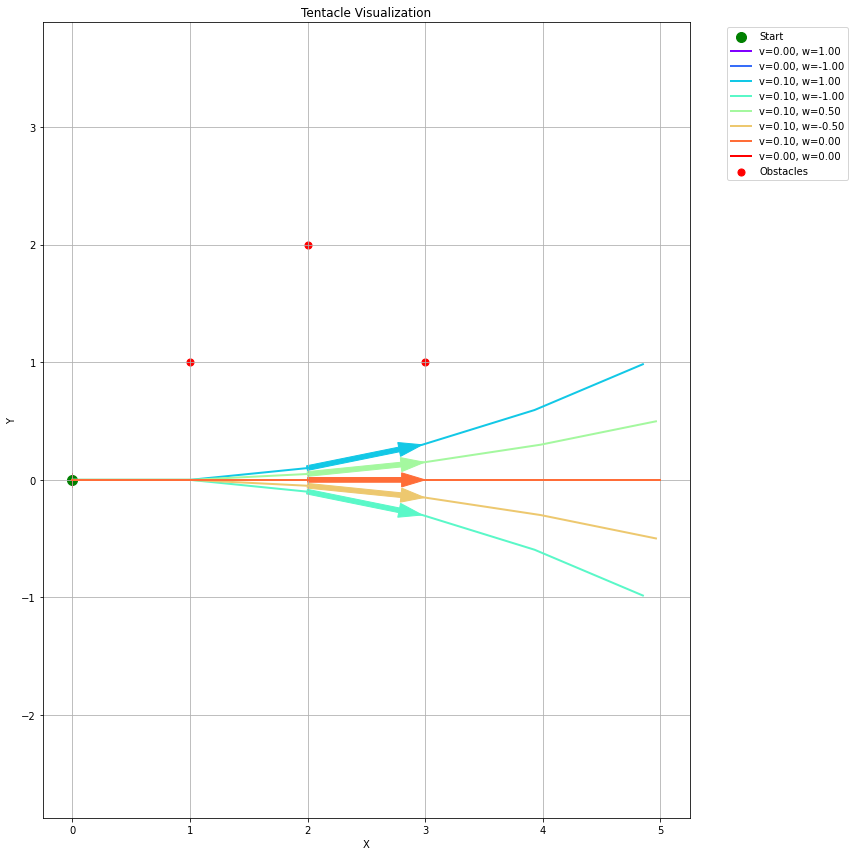

eheheheheeh


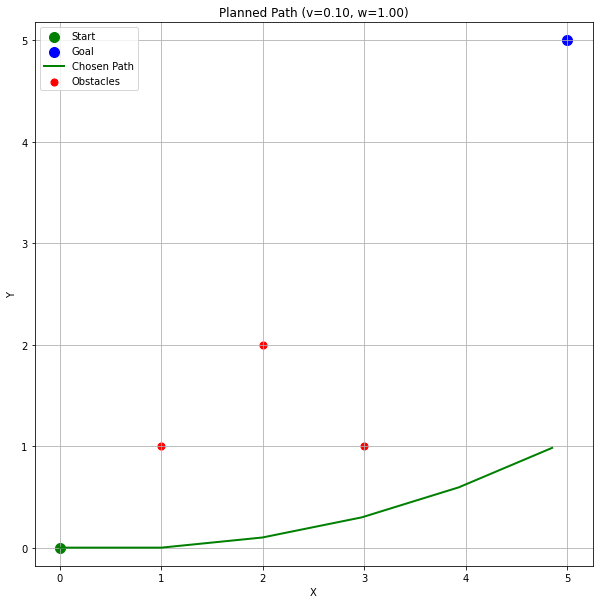

In [4]:
from tentacle_planner import TentaclePlanner
import numpy as np
# Create a TentaclePlanner instance
obstacles = np.array([[1, 1], [2, 2], [3, 1]])  # Example obstacles
planner = TentaclePlanner(obstacles)

# Visualize all tentacles from a starting position
planner.visualize_tentacles(0, 0, 0)

# Visualize the planned path to a goal
planner.visualize_plan(5, 5, np.pi / 4, 0, 0, 0)